# Music Genre Recognition using Convolutional Neural Networks

## What is Music Genre Recognition?

Music Genre Recognition is an important field of research in Music Information Retrieval (MIR). A music genre is a conventional category that identifies some pieces of music as belonging to a shared tradition or set of conventions, i.e. it depicts the style of music.

Music Genre Recognition involves making use of features such as spectrograms, MFCC’s for predicting the genre of music.

## Feature Extraction

We are going to make use of GTZAN Dataset. This Dataset comprises 10 genres namely Blues, Classical, Country, Disco, Hip Hop, Jazz, Metal, Pop, Reggae, Rock.

Each genre comprises `100` audio files (.wav) of `30` seconds each. That means we have `1000` training examples and if we keep `20%` of them for validation then just `800` training examples.

We can learn the genre of a song or music by listening to it for just `4-5` seconds, so `30` seconds are little too much information for the model to take at once!!! That is why we decided to split a single audio file into `10` audio files each of `3` seconds.

Now, our training examples have become tenfold, i.e. each genre has `1000` training examples and total training examples are `10000`. So, we increased our dataset and this will be helpful for a deep learning model because it always requires more data.

As we are going to use a *Convolutional Neural Network*, we need an image as an input, for this we will use the [mel spectrograms](./anexo/mfcc-implementation-and-tutorial.ipynb) of audio files and save them as image files (.jpg or .png). We can also read [this article](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53#:~:text=A%20mel%20spectrogram%20is%20a,converted%20to%20the%20mel%20scale.) which talks about mel spectrograms.

### How to do it...

1. Download and extract the dataset on `source_dir`. 

In [1]:
source_dir = '../../Machine-Learning/Music-Genre-Classification/'

2. Import all the required packages:

In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import librosa
from pydub import AudioSegment
import shutil
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import (Input, Dense, Activation, BatchNormalization, Flatten,
                          Conv2D, MaxPooling2D, Dropout)
from keras.models import Model, load_model
from keras.optimizers import Adam
from PIL import Image

**NOTA:** chequear el estado actual de los directorios/archivos generados!!!

In [23]:
# Specify path
path = os.path.join(source_dir,'audio3sec')
  
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if isExist: print('CORRER EL CUADERNO A PARTIR DE SECCION: Results')

CORRER EL CUADERNO A PARTIR DE SECCION: Results


3. Make empty directories for each genre:

In [ ]:
genres = 'blues classical country disco pop hiphop metal reggae rock'
genres = genres.split()

for g in genres:
    path_audio = os.path.join(source_dir,'audio3sec',g)
    path_train = os.path.join(source_dir,'spectrograms3sec/train',g)
    path_test = os.path.join(source_dir,'spectrograms3sec/test',g)
    os.makedirs(path_audio)
    os.makedirs(path_train)
    os.makedirs(path_test)

4. Split the audio files. We will make use of *AudioSegment* from [PyDub package](http://pydub.com/):

In [ ]:
for g in genres:
    j = 0
    lista_songs = os.listdir(os.path.join(source_dir,'genres',g))
    for filename in lista_songs:
        j = j+1
        print(filename)
        song = os.path.join(source_dir,'genres',g,filename)
        # Load audio into PyDub
        old = AudioSegment.from_wav(song)
        for w in range(0,10):
            # Slice audio: PyDub does things in miliseconds
            t1 = 3*(w)*1000 # t1=0,3,6,9,...,27 seconds
            t2 = 3*(w+1)*1000 # t2=3,6,9,12,...,30 seconds
            new = old[t1:t2]
            # Save the result
            split_song = os.path.join(source_dir,'audio3sec',g,g+str(j)+str(w)+'.wav')
            new.export(split_song, format='wav')

So, there are three *for loops* here. First, we loop over the genres we have, then for that genre a second *for loop* goes through every audio file, and a third *for loop* splits the audio file into 10 parts and save them into empty directories we created previously.

5. Generate *mel spectrograms* for the audio files. We will make use of [Librosa](https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html#librosa.feature.melspectrogram):

In [ ]:
for g in genres:
    j = 0
    lista_songs = os.listdir(os.path.join(source_dir,'audio3sec',g))
    for filename in lista_songs:
        j = j+1
        print(filename)
        song = os.path.join(source_dir,'audio3sec',g,filename)
        # Load audio into Librosa
        y, sr = librosa.load(song, duration=3)
        mel_spect = librosa.feature.melspectrogram(y, sr)
        mel_spect_dB = librosa.power_to_db(mel_spect, ref=np.max)
        fig = plt.Figure()
        canvas = FigureCanvas(fig)
        p = plt.imshow(mel_spect_dB)
        # Save the result
        split_spect = os.path.join(source_dir,'spectrograms3sec/train',g,g+str(j)+'.png')
        plt.savefig(split_spect)

So, there are two *for loops* here. First, we loop over the genres we have, then for that genre a second *for loop* goes through every split audio file, generate a *mel spectrogram* and save it into empty directories we created previously.

6. Split the data into *training set* and *validation set*. For each genre, we randomly shuffle filenames, select top 100 filenames and move them to test/validation directory:

In [ ]:
for g in genres:
    origen_dir = os.path.join(source_dir,'spectrograms3sec/train',g)
    destino_dir = os.path.join(source_dir,'spectrograms3sec/test',g)
    lista_spects = os.listdir(origen_dir)
    random.shuffle(lista_spects)
    test_files = lista_spects[0:100]
    for f in test_files:
        print(f)
        shutil.move(origen_dir+'/'+f,destino_dir)

## Data Pre-processing 

As we know, data should be formatted into floating-point tensors before being fed into the network. Currently, the data sits on a drive as PNG files, so the steps for getting it into the network are:

* 1. Read the picture files.
* 2. Decode the PNG content to RGBA grids of pixels.
* 3. Convert these into floating-point tensors.
* 4. Rescale the pixel values (between 0 and 255) to the [0,1] interval.

Fortunately, Keras has a module with [image-processing tools](https://keras.io/api/preprocessing/image/), located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator`, which let us quickly set up **Python generators** that can automatically turn image files on disk into batches of preprocessed tensors. 

In [4]:
# Rescales all images
train_datagen = ImageDataGenerator(rescale=1./255)
vali_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join(source_dir,'spectrograms3sec/train/')
vali_dir = os.path.join(source_dir,'spectrograms3sec/test/')

# Resizes all images
# We need categorical labels (because we use categorical_crossentropy loss)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=128)
vali_generator = vali_datagen.flow_from_directory(vali_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=128)

Found 8100 images belonging to 9 classes.
Found 900 images belonging to 9 classes.


**flow_from_directory()** method: automatically infers the labels using our directory structure and encodes them accordingly.

The argument `class_mode` determines the type of label arrays that are returned. In present case, `categorical` will be 2D one-hot encoded labels. 

This method returns a *DirectoryIterator* yielding tuples of `(x,y)` where `x` is a numpy array containing a batch of images with shape `(batch_size, target_size, channels)` and `y` is a numpy array of corresponding labels.

**ImageDataGenerator** class: makes training on large datasets simple by using the fact that model gets trained on only one batch per step. So, while training, data generator just loads one batch into memory at a time, so there is no exhaustion of memory resources!

We can also read [this article](https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c) which talks about data generators.

**NOTE:** A *Python generator* is an object that acts as an iterator: it’s an object we can use with the `for ... in` operator.

Let’s look at the output of one of these generators: the generator yields these batches indefinitely: it loops endlessly over the images in the target folder. For this reason, we need to break the iteration loop at some point:

In [5]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (128, 288, 432, 4)
labels batch shape: (128, 9)


Note that the generator yields batches of `288 × 432` RGBA images and categorical labels. There are `128` samples in each batch (the batch size). 

## Convolutional Network Model

We will build our CNN model using keras. Model comprises `5` *Convolutional layers* and `1` *Dense layer* with `softmax` activation to output class probabilities. 

In [6]:
def GenreModel(input_shape=(288,432,4),classes=9):
    X_input = Input(input_shape)
    
    X = Conv2D(8,kernel_size=(3,3),strides=(1,1))(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)
    
    X = Conv2D(16,kernel_size=(3,3),strides=(1,1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)
    
    X = Conv2D(32,kernel_size=(3,3),strides=(1,1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)
    
    X = Conv2D(64,kernel_size=(3,3),strides=(1,1))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)
    
    X = Conv2D(128,kernel_size=(3,3),strides=(1,1))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)
    
    X = Flatten()(X)
    
    X = Dense(classes, activation='softmax', name='fc'+str(classes))(X)
    
    model = Model(inputs=X_input,outputs=X,name='GenreModel')
    
    return model

In this case, we configure our CNN (**convnet**) to process inputs of size `(image_height, image_width, image_channels) = (288, 432, 4)`. Additionally, the strides for the filter are `(1, 1)` given that the filter moves one step at a time both horizontally and vertically. 

This way, the convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers. 

Remember that we built a **small convnet** for MNIST dataset in the previous section (cuaderno 008). In the present case (GTZAN dataset) we are dealing with bigger images and a more complex problem, so we make our **network larger**: it has more `Conv2D + MaxPooling2D` stages!!! 

This serves both to **augment** the capacity of the network and to further **reduce** the size of the *feature maps* so they are not overly large when we reach the `Flatten` layer. Let’s display the architecture of the convnet:

In [7]:
model = GenreModel(input_shape=(288,432,4),classes=9)
model.summary()

Model: "GenreModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 288, 432, 4)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 286, 430, 8)       296       
_________________________________________________________________
batch_normalization (BatchNo (None, 286, 430, 8)       32        
_________________________________________________________________
activation (Activation)      (None, 286, 430, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 143, 215, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 141, 213, 16)      1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 141, 213, 16)      6

Here, we **start** from inputs of size `288 × 432` and **end up** with feature maps of size `7 × 11` just before the `Flatten` layer.

We see that the output of every `Conv2D` and `MaxPooling2D` layer is a 3D tensor of shape `(height, width, channels)`. The *width* and *height* dimensions tend to shrink as we go deeper in the network. The *number of channels* is controlled by the first argument passed to the Conv2D layers (8, 16, 32, 64 or 128).

The next step is to feed the last output tensor of shape `(7, 11, 128)` into a stack of *Dense layers*. First we have to flatten the 3D outputs to 1D. We do 9-way classification, using a final layer with 9 outputs (a `Dense` layer of size `9`) and a `softmax` activation. 

**NOTE:** The depth of the feature maps progressively *increases* in the network (from `8` to `128`), whereas the size of the feature maps *decreases* (from `288 × 432` to `7 × 11`). This is a pattern we’ll see in almost all convnets.

## Training

For the compilation step, we’ll go with the `Adam` optimizer:

In [8]:
opt = Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Let’s fit the model to the data using the generator. We do so using the `fit_generator` method, the equivalent of `fit` for data generators. It expects as its first argument a Python generator that will yield batches of training inputs and targets indefinitely. Additionally, we can pass a `validation_data` argument ... this generator is also expected to yield batches of validation data endlessly.

In [9]:
history = model.fit_generator(train_generator, epochs=70, validation_data=vali_generator)

/home/ale/miniconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/70
64/64 [==============================] - 186s 3s/step - loss: 2.1074 - accuracy: 0.2171 - val_loss: 2.2036 - val_accuracy: 0.1100
Epoch 2/70
64/64 [==============================] - 142s 2s/step - loss: 1.6320 - accuracy: 0.4274 - val_loss: 2.2178 - val_accuracy: 0.1478
Epoch 3/70
64/64 [==============================] - 134s 2s/step - loss: 1.4435 - accuracy: 0.4809 - val_loss: 2.1895 - val_accuracy: 0.2078
Epoch 4/70
64/64 [==============================] - 139s 2s/step - loss: 1.3243 - accuracy: 0.5244 - val_loss: 2.0788 - val_accuracy: 0.2033
Epoch 5/70
64/64 [==============================] - 143s 2s/step - loss: 1.2423 - accuracy: 0.5513 - val_loss: 1.8290 - val_accuracy: 0.2578
Epoch 6/70
64/64 [==============================] - 140s 2s/step - loss: 1.1498 - accuracy: 0.5987 - val_loss: 1.5845 - val_accuracy: 0.3667
Epoch 7/70
64/64 [==============================] - 140s 2s/step - loss: 1.0996 - accuracy: 0.6157 - val_loss: 1.3344 - val_accuracy: 0.5000
Epoch 8/70
64

Epoch 59/70
64/64 [==============================] - 136s 2s/step - loss: 0.1400 - accuracy: 0.9867 - val_loss: 0.5813 - val_accuracy: 0.8022
Epoch 60/70
64/64 [==============================] - 136s 2s/step - loss: 0.1335 - accuracy: 0.9850 - val_loss: 0.5911 - val_accuracy: 0.7844
Epoch 61/70
64/64 [==============================] - 136s 2s/step - loss: 0.1225 - accuracy: 0.9898 - val_loss: 0.5919 - val_accuracy: 0.7989
Epoch 62/70
64/64 [==============================] - 131s 2s/step - loss: 0.1214 - accuracy: 0.9917 - val_loss: 0.5906 - val_accuracy: 0.7956
Epoch 63/70
64/64 [==============================] - 139s 2s/step - loss: 0.1116 - accuracy: 0.9910 - val_loss: 0.5927 - val_accuracy: 0.7856
Epoch 64/70
64/64 [==============================] - 132s 2s/step - loss: 0.1121 - accuracy: 0.9936 - val_loss: 0.5919 - val_accuracy: 0.7956
Epoch 65/70
64/64 [==============================] - 137s 2s/step - loss: 0.1109 - accuracy: 0.9914 - val_loss: 0.6024 - val_accuracy: 0.7867
Epoch 

After training for 70 epochs, we got training accuracy of 99.45% and on validation 80.11%. Extract loss and accuracy of the model over training and validation data during training:

In [10]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(val_loss_values) + 1)

And now visualize!

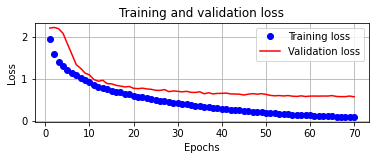

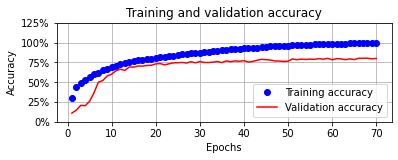

In [11]:
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

Let's save the model as a HDF5 file. This file contains:

* the architecture of the model (topology), allowing to re-create the model;
* the weights of the model;
* the training configuration (loss, optimizer);
* the state of the optimizer, allowing to resume training exactly where we left off.

In [19]:
model_file = os.path.join(source_dir,'results','genre.h5')
model.save(model_file)

## Results

Now, we will pick a song and try to recommend the genre of that song using our model.

In [70]:
def convert_mp3_to_wav(source_dir,filename):
    # Load audio into PyDub
    song_m = os.path.join(source_dir,'results',filename+'.mp3')
    mp3 = AudioSegment.from_mp3(song_m)
    # Save
    song_w = os.path.join(source_dir,'results',filename+'.wav')
    mp3.export(song_w, format="wav")

def extract_relevant(source_dir,filename,t1,t2):
    # Load audio into PyDub
    song_w = os.path.join(source_dir,'results',filename+'.wav')
    wav = AudioSegment.from_wav(song_w)
    # Slice audio (miliseconds)
    wav = wav[1000*t1:1000*t2]
    # Save
    split_song = os.path.join(source_dir,'results','split_'+filename+'.wav')
    wav.export(split_song, format='wav')

def create_melspectrogram(source_dir,filename):
    # Load audio into Librosa
    split_song = os.path.join(source_dir,'results','split_'+filename+'.wav')
    y, sr = librosa.load(split_song, duration=3)
    mel_spect = librosa.feature.melspectrogram(y, sr)
    mel_spect_dB = librosa.power_to_db(mel_spect, ref=np.max)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    p = plt.imshow(mel_spect_dB)
    # Save 
    split_spect = os.path.join(source_dir,'results','spect_'+filename+'.png')
    plt.savefig(split_spect)    

def predict(source_dir,filename,model):
    split_spect = os.path.join(source_dir,'results','spect_'+filename+'.png')
    # Convert .png string to PIL image object
    split_spect_pil = Image.open(split_spect) 
    # Convert PIL Image instance to Numpy array
    image = img_to_array(split_spect_pil)
    print(image.shape)    
    
    # Predict the label of the image using the built model
    # 1. Calculate the expected output:
    image = np.reshape(image,(1,288,432,4))
    prediction = model.predict(image/255)
    print(np.shape(prediction))
    prediction = prediction.reshape((9,))
    print(prediction)
    # 2. Obtain the index that has the highest probability value:
    class_label = np.argmax(prediction)
    print(class_label)

    return class_label,prediction

(288, 432, 4)
(1, 9)
[2.3408249e-06 6.3520696e-05 3.1285521e-02 1.7146761e-02 4.7790052e-04
 4.9090844e-01 2.9819988e-02 1.2966101e-02 4.1732943e-01]
5
The Genre of Song is --> metal


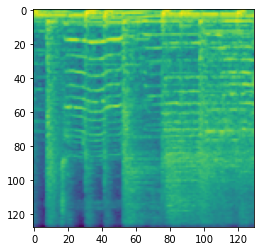

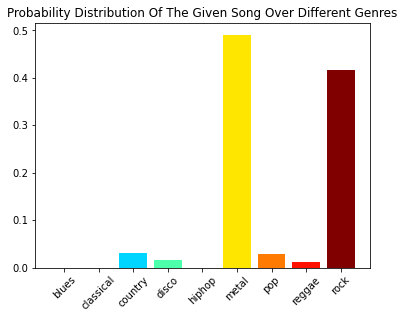

In [75]:
filename = 'Nirvana-Smells-Like-Teen-Spirit'

convert_mp3_to_wav(source_dir,filename)
extract_relevant(source_dir,filename,40,50)
create_melspectrogram(source_dir,filename)

# Load the model
rec_model = load_model(model_file) # reconstructed model

# Predict the genre
class_label,prediction = predict(source_dir,filename,rec_model)
class_labels = ['blues','classical','country','disco','hiphop','metal','pop','reggae','rock']
print('The Genre of Song is --> '+class_labels[class_label])

# Grafica
color_data = [1,2,3,4,5,6,7,8,9]
my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0,vmax=9)
fig,ax = plt.subplots(figsize=(6,4.5))
ax.bar(x=class_labels,height=prediction,color=my_cmap(my_norm(color_data)))
plt.xticks(rotation=45)
ax.set_title('Probability Distribution Of The Given Song Over Different Genres')
plt.show()